In [47]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

Num GPUs Available:  1


In [48]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [49]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
	"PlantVillage",
	shuffle=True,
	image_size=(IMAGE_SIZE,IMAGE_SIZE),
	batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [50]:
class_names = dataset.class_names
class_names

['Early Blight', 'Healthy', 'Late Blight']

In [51]:
len(dataset)

68

(256, 256, 3)


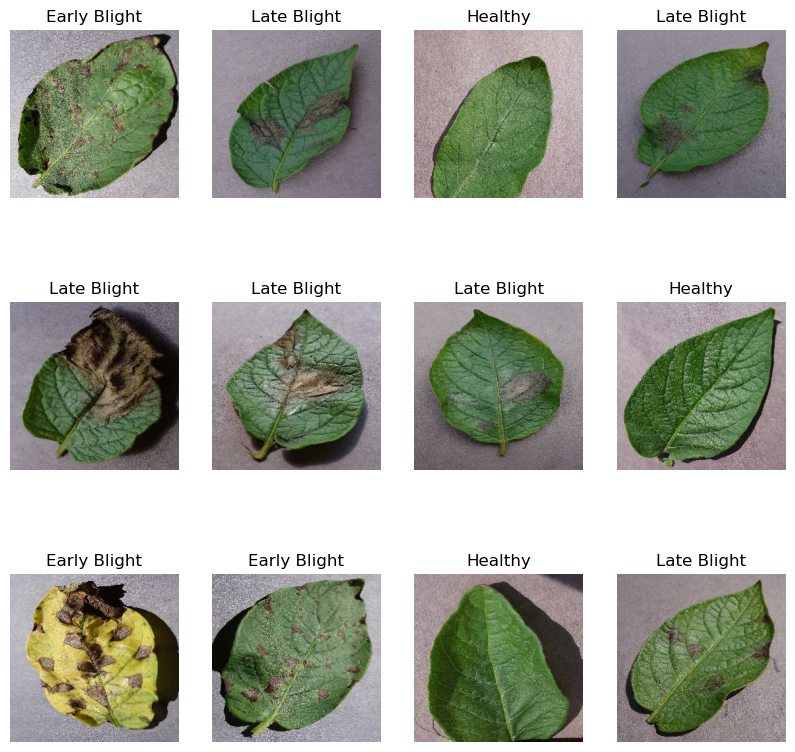

In [52]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

    

In [53]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)
        
    train_size = int(train_split*ds_size)
    val_size = int(val_split* ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    
    return train_ds,val_ds,test_ds

In [54]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [55]:
print(len(train_ds),len(val_ds),len(test_ds))

54 6 8


In [56]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [57]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [58]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [59]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
	layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
	layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = "relu"),
    layers.Dense(n_classes, activation = 'softmax')
    
])
model.build(input_shape=input_shape)

In [60]:
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [61]:
model.compile(
	optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [62]:
history = model.fit(
	train_ds,
    epochs=EPOCHS,
    batch_size= BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/50


54/54 [==============================] - 17s 210ms/step - loss: 0.9096 - accuracy: 0.5053 - val_loss: 0.8387 - val_accuracy: 0.5990
Epoch 2/50
54/54 [==============================] - 10s 179ms/step - loss: 0.6617 - accuracy: 0.7019 - val_loss: 0.5630 - val_accuracy: 0.6979
Epoch 3/50
54/54 [==============================] - 10s 185ms/step - loss: 0.3151 - accuracy: 0.8768 - val_loss: 0.3728 - val_accuracy: 0.8438
Epoch 4/50
54/54 [==============================] - 10s 188ms/step - loss: 0.1900 - accuracy: 0.9266 - val_loss: 0.5864 - val_accuracy: 0.8125
Epoch 5/50
54/54 [==============================] - 10s 185ms/step - loss: 0.1338 - accuracy: 0.9513 - val_loss: 0.5073 - val_accuracy: 0.7917
Epoch 6/50
54/54 [==============================] - 10s 188ms/step - loss: 0.1008 - accuracy: 0.9642 - val_loss: 0.2120 - val_accuracy: 0.9115
Epoch 7/50
54/54 [==============================] - 10s 192ms/step - loss: 0.1194 - accuracy: 0.9572 - val_loss: 0.1805 - val_accuracy: 0.9271
Epoch 8/50

In [63]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 47ms/step - loss: 0.0189 - accuracy: 0.9961


In [64]:
history

In [65]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [66]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 1.0, 'Training and validation loss')

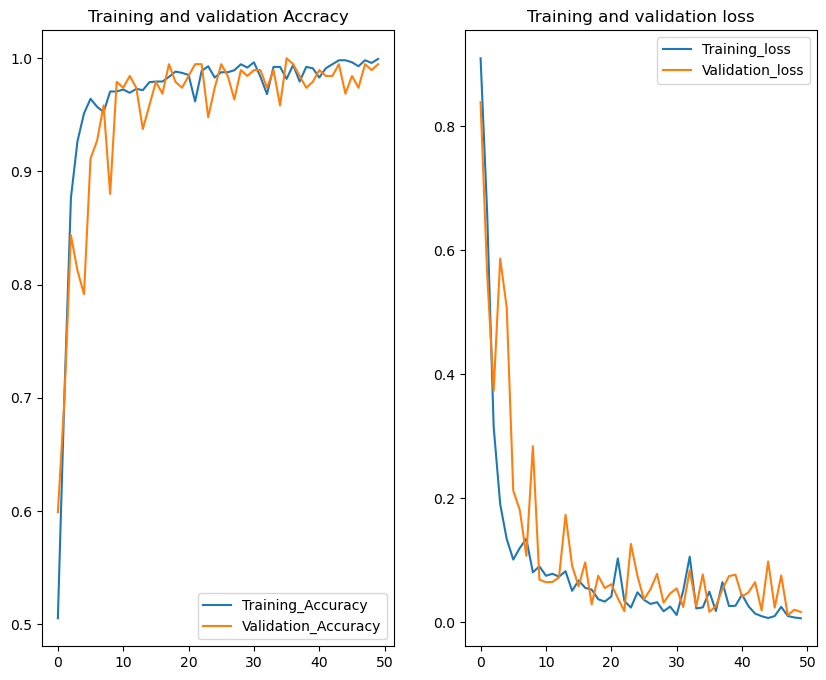

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training_Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation_Accuracy')
plt.legend(loc="lower right")
plt.title('Training and validation Accracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training_loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation_loss')
plt.legend(loc="upper right")
plt.title('Training and validation loss')

First image to predict
actual label = Late Blight
1/1 [==============================] - 0s 200ms/step
Predicted label = Late Blight


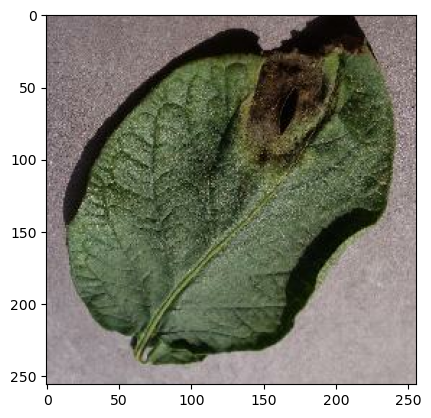

In [68]:
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0]
    
    print("First image to predict")
    plt.imshow(first_image)
    print(f"actual label = {class_names[first_label]}")
          
    batch_prediction = model.predict(image_batch)
    print(f"Predicted label = {class_names[np.argmax(batch_prediction[0])]}")

In [69]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 26ms/step


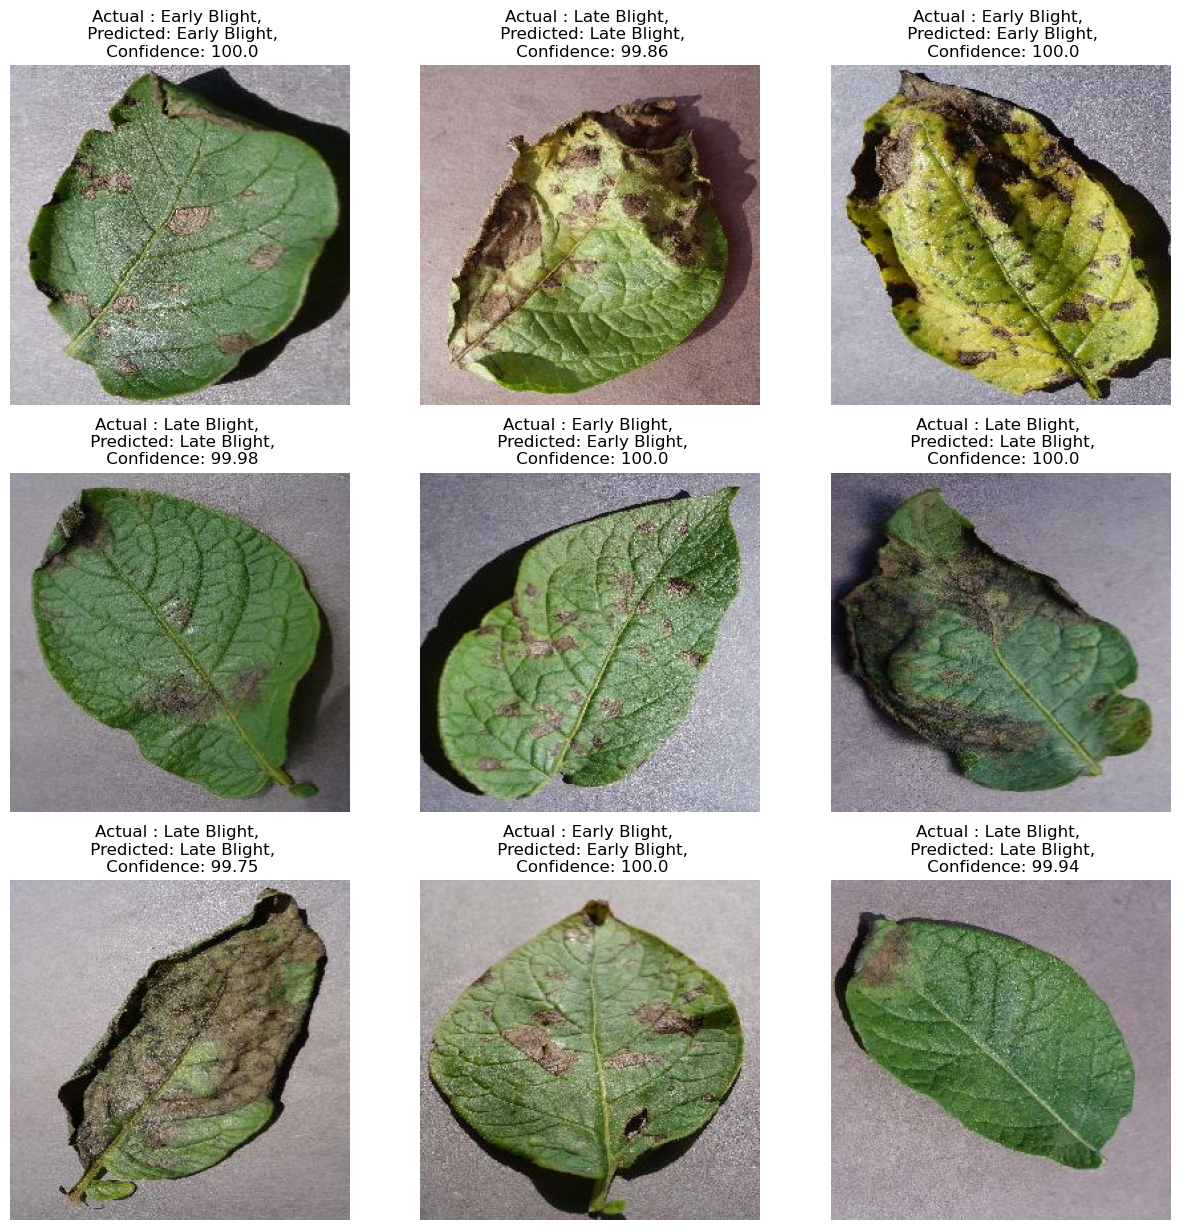

In [73]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual : {actual_class}, \n Predicted: {predicted_class},\n Confidence: {confidence}")
        plt.axis('off')

In [72]:
model_version = max([int(i) for i in os.listdir("../saved_models")])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/4\assets


INFO:tensorflow:Assets written to: ../saved_models/4\assets
